In [ ]:
import pandas as pd

# Préparation de l’environnement : 
# Import des librairies nécessaires avant modélisation.
# ------------------------------------------------------------

# Chargement des données brutes : 
# Lecture des 3 datasets fournis par le département RH.
# ------------------------------------------------------------

sirh = pd.read_csv("../data/sirh.csv")
perf = pd.read_csv("../data/performance.csv")
survey = pd.read_csv("../data/survey.csv")

# Nettoyage des colonnes : 
# Uniformisation des noms pour éviter erreurs lors des jointures.
# ------------------------------------------------------------
sirh.columns = sirh.columns.str.lower().str.strip()
perf.columns = perf.columns.str.lower().str.strip()
survey.columns = survey.columns.str.lower().str.strip()

# Création du DataFrame central : 
# Fusion INNER pour ne garder que les employés présents dans les 3 sources.
# ------------------------------------------------------------

df = (
    sirh
    .merge(perf, on="employee_id", how="inner")
    .merge(survey, on="employee_id", how="inner")
)

df.head()


,employee_id,age,salary,tenure_years,department,gender,job_level,performance_score,manager_rating,satisfaction_global,work_life_balance,engagement_score,stress_level,has_left
0,1,28,38000,1.2,IT,F,Junior,3.2,3.0,2.5,2.8,3.0,4.2,1
1,2,34,45000,3.5,Finance,M,Intermediate,4.1,4.0,3.8,3.5,4.0,2.1,0
2,3,42,52000,6.8,HR,F,Senior,4.8,5.0,4.5,4.2,4.8,1.9,0
3,4,31,40000,2.0,IT,M,Junior,3.0,2.8,2.9,2.7,3.0,3.9,1
4,5,26,36000,0.8,Marketing,F,Junior,2.5,2.0,2.3,2.1,2.5,4.5,1


In [ ]:
# Identification des variables pertinentes : 
# Définition des colonnes numériques et catégorielles.
# ------------------------------------------------------------

target = "has_left"

num_cols = ["age", "salary", "tenure_years", "satisfaction_global", "stress_level"]
cat_cols = ["department", "gender", "job_level"]

X = df[num_cols + cat_cols]
y = df[target]


In [ ]:
# Gestion du déséquilibre des classes : 
# Stratification pour conserver la proportion de départs/départs non observés.
# ------------------------------------------------------------

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((8, 8), (2, 8))

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Préparation des données pour modélisation : 
# Pipelines séparés pour numériq + catégoriel = bonne pratique.
# ------------------------------------------------------------

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Baseline pour contextualiser les performances : 
# Modèle Dummy "most frequent" = référence minimale à dépasser.
# ------------------------------------------------------------

dummy = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DummyClassifier(strategy="most_frequent"))
])

dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print(classification_report(y_test, y_pred_dummy))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Users\selma\Desktop\Technovaa\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\selma\Desktop\Technovaa\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\selma\Desktop\Technovaa\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

In [ ]:
from sklearn.linear_model import LogisticRegression

# Modèle linéaire pour comparaison : 
# Une régression logistique bien calibrée avec class_weight balanced.
# ------------------------------------------------------------

logreg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_lr))
print("AUC :", roc_auc_score(y_test, y_proba_lr))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

AUC : 1.0


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

# Modèle non-linéaire + gestion du déséquilibre : 
# Application de SMOTE AVANT le modèle pour équilibrer les classes.
# ------------------------------------------------------------

rf = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(k_neighbors=1, random_state=42)),  
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42
    ))
])

rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Fine-tuning des hyperparamètres :
# GridSearch + CV stratifiée = méthodologie rigoureuse.
# ------------------------------------------------------------

pipe_rf = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(k_neighbors=1, random_state=42)),
    ("model", RandomForestClassifier(random_state=42))
])

# Hyperparamètres à tester
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5]
}

# Validation croisée
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearch
grid = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Meilleure AUC :", grid.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Meilleurs paramètres : {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Meilleure AUC : 1.0


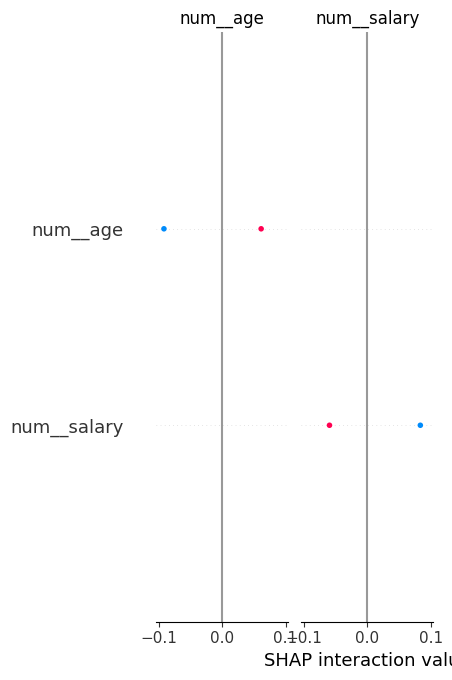

In [ ]:
import shap
import numpy as np

# Préparation des données pour l’interprétabilité : 
# On applique le preprocess seul pour obtenir X_train_pre/X_test_pre.
# ------------------------------------------------------------

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

# 2) Convertir si sparse
if hasattr(X_train_pre, "toarray"):
    X_train_pre = X_train_pre.toarray()
    X_test_pre = X_test_pre.toarray()

# 3) Récupérer les noms des colonnes transformées
feature_names = preprocessor.get_feature_names_out()

#  Interprétation globale du modèle : 
# On entraîne un modèle RF simple pour générer des valeurs SHAP cohérentes.
# ------------------------------------------------------------
rf_shap = RandomForestClassifier(n_estimators=200, random_state=42)
rf_shap.fit(X_train_pre, y_train)

# 5) Utiliser le NOUVEL EXPLAINER (recommandé)
explainer = shap.Explainer(rf_shap, X_train_pre, feature_names=feature_names)

# 6) Calcul des valeurs SHAP
shap_values = explainer(X_test_pre)

# 7) Summary plot global
shap.summary_plot(shap_values.values, X_test_pre, feature_names=feature_names)



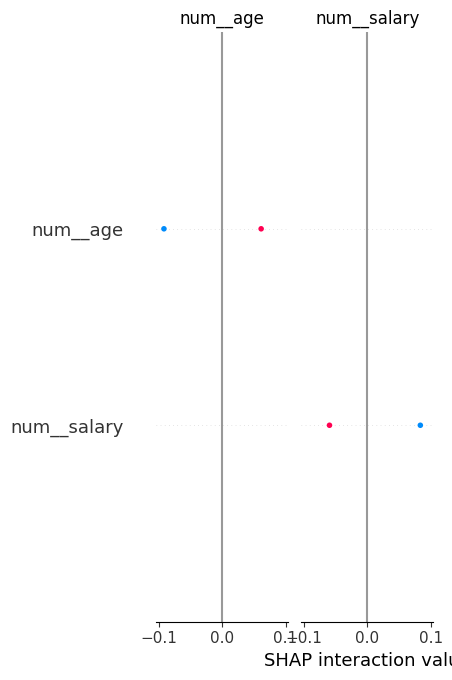

In [21]:
# Analyse des facteurs influençant le départ : 
# SHAP summary plot = classement global des variables (type Beeswarm).
# ------------------------------------------------------------

shap.summary_plot(shap_values.values, 
                  X_test_pre, 
                  feature_names=feature_names, 
                  plot_type="dot" # == beeswarm plot
)


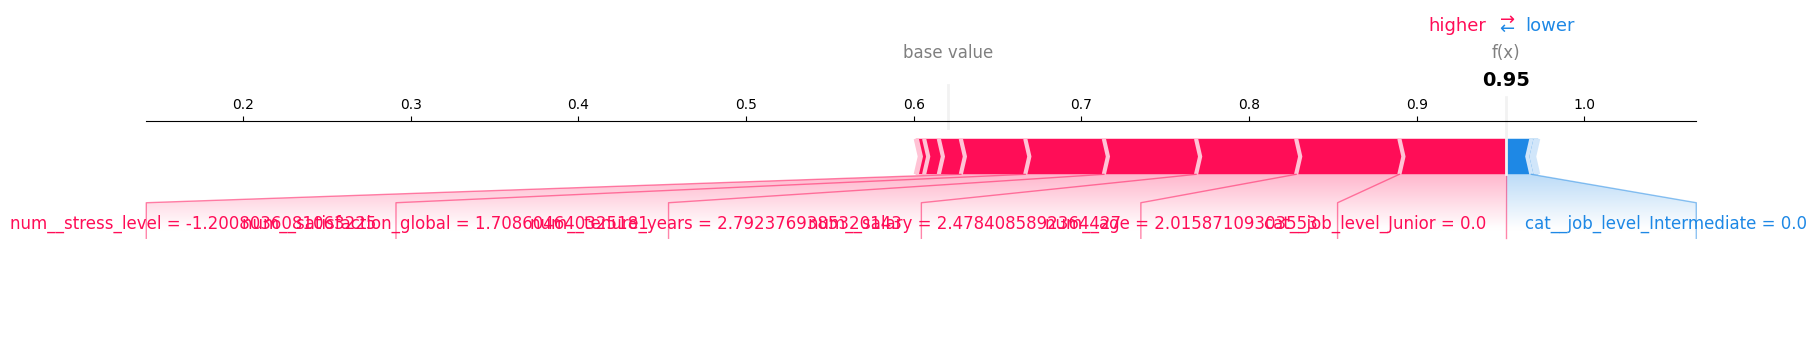

In [20]:
import shap
import numpy as np

idx = 0  # individu à expliquer

# 1) Détection automatique des formats
base_value = explainer.expected_value
shap_val = shap_values.values

if isinstance(base_value, (list, np.ndarray)):
    base_value = base_value[0]

if shap_val.ndim == 3:
    shap_val = shap_val[:, :, 0]

# 2) Force plot version MATPLOTLIB (solution stable)
shap.plots.force(
    base_value,
    shap_val[idx],
    X_test_shap.iloc[idx],   # données de l'individu avec noms de colonnes
    matplotlib=True          # 🔥 indispensable pour éviter le JavaScript
)
